In [35]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

In [36]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [37]:
# Loading PME data 
df_pme = pd.read_csv('pme.csv')
df_pme = df_pme.drop(['Unnamed: 0'], axis =1)
df_pme.shape

(1720, 2)

In [38]:
df = pd.read_csv("FinalDataSet_VC_BO.csv")
df.head(2)

,Fund_Id,Fund_Name,Firm_Name,Fund_Type,Fund_Size,Fund_Number_Overall,Fund_Number_Series,Called_Pcent,Distr_DPI_Pcent,Value_RVPI_Pcent,...,Fund_Type_Venture_Cap,Local_Currency_USD,Local_Currency_EUR,Fund_Status_Closed,Fund_Status_Liquidated,Fund_Focus_US,Fund_Focus_Europe,Fund_Focus_Asia,Geographic_Scope_Diversified,Industry_Diversified
0,3,1818 Fund II,Brown Brothers Harriman,Buyout,475.0,2,2,88.5,180.74,0.0,...,0,1,0,0,1,1,0,0,0,0
1,9,Riverside Capital Appreciation Fund 2000,Riverside Company,Buyout,412.8,4,3,91.5,175.80,0.0,...,0,1,0,0,1,1,0,0,0,0


In [39]:
df.shape

(1719, 29)

In [40]:
df = df.merge(df_pme, how="inner", on=["Fund_Id"])

In [41]:
df.head(2)

,Fund_Id,Fund_Name,Firm_Name,Fund_Type,Fund_Size,Fund_Number_Overall,Fund_Number_Series,Called_Pcent,Distr_DPI_Pcent,Value_RVPI_Pcent,...,Local_Currency_USD,Local_Currency_EUR,Fund_Status_Closed,Fund_Status_Liquidated,Fund_Focus_US,Fund_Focus_Europe,Fund_Focus_Asia,Geographic_Scope_Diversified,Industry_Diversified,PME
0,3,1818 Fund II,Brown Brothers Harriman,Buyout,475.0,2,2,88.5,180.74,0.0,...,1,0,0,1,1,0,0,0,0,0.914287
1,9,Riverside Capital Appreciation Fund 2000,Riverside Company,Buyout,412.8,4,3,91.5,175.80,0.0,...,1,0,0,1,1,0,0,0,0,1.463056


In [42]:
df.shape

(1719, 30)

In [43]:
df.PME.isna().sum()

0

In [44]:
df = df.dropna()

In [45]:
df.to_csv("Data_for_modeling_VC_BO.csv", index = False)

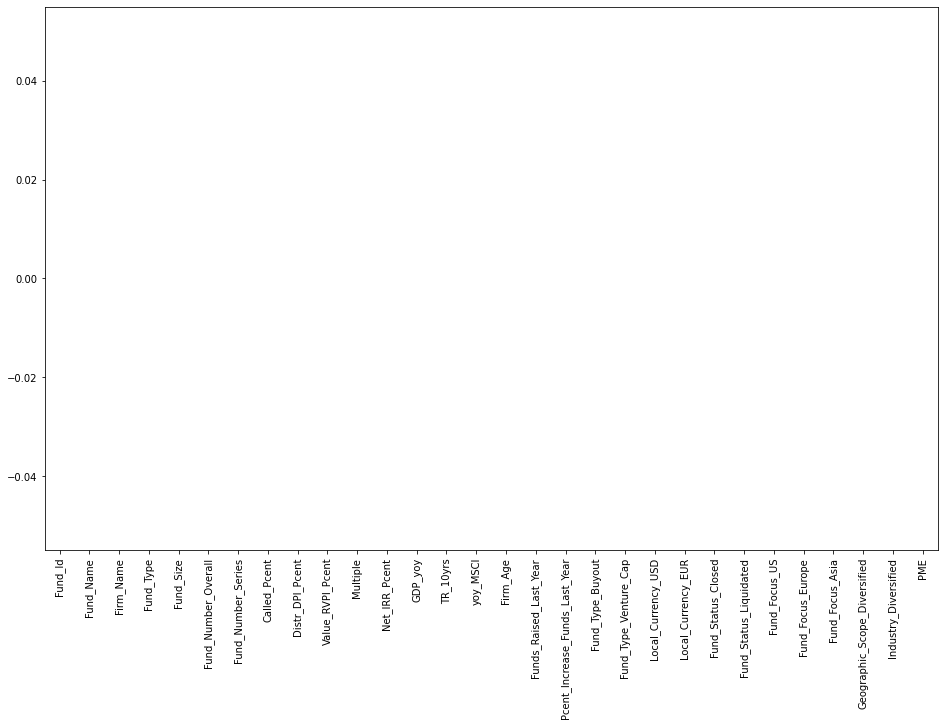

In [46]:
df.isna().sum().plot(kind="bar", figsize=(16,10));

# Dropping Columns 

In [47]:
# Dropping columns 
df.drop(["Fund_Id","Fund_Type", "Fund_Name","Firm_Name", "Net_IRR_Pcent", 
"Called_Pcent", "Distr_DPI_Pcent", "Value_RVPI_Pcent", "Multiple", 
          "Fund_Status_Closed", "Fund_Status_Liquidated" ], axis=1, inplace=True)

In [48]:
df[df.Fund_Type_Buyout == 1].count()

Fund_Size                         1058
Fund_Number_Overall               1058
Fund_Number_Series                1058
GDP_yoy                           1058
TR_10yrs                          1058
yoy_MSCI                          1058
Firm_Age                          1058
Funds_Raised_Last_Year            1058
Pcent_Increase_Funds_Last_Year    1058
Fund_Type_Buyout                  1058
Fund_Type_Venture_Cap             1058
Local_Currency_USD                1058
Local_Currency_EUR                1058
Fund_Focus_US                     1058
Fund_Focus_Europe                 1058
Fund_Focus_Asia                   1058
Geographic_Scope_Diversified      1058
Industry_Diversified              1058
PME                               1058
dtype: int64

# Division of data set into two as per Buyout and venture capital

In [49]:
df = df[df.Fund_Type_Buyout == 1]

# Target Variable

In [50]:
df['PME'].describe()

count    1058.000000
mean        1.203947
std         0.452146
min         0.000000
25%         0.948332
50%         1.144871
75%         1.378527
max         3.949609
Name: PME, dtype: float64

<AxesSubplot:>

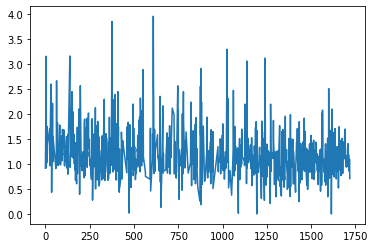

In [51]:
df["PME"].plot()

In [52]:
df["PME"]=   df["PME"].apply(lambda x: float(int(1) if x >= 1 else int(0)))

In [53]:
df.head(2)

,Fund_Size,Fund_Number_Overall,Fund_Number_Series,GDP_yoy,TR_10yrs,yoy_MSCI,Firm_Age,Funds_Raised_Last_Year,Pcent_Increase_Funds_Last_Year,Fund_Type_Buyout,Fund_Type_Venture_Cap,Local_Currency_USD,Local_Currency_EUR,Fund_Focus_US,Fund_Focus_Europe,Fund_Focus_Asia,Geographic_Scope_Diversified,Industry_Diversified,PME
0,475.0,2,2,5.88,7.008845,-7.141309,4,101,0.905660,1,0,1,0,1,0,0,0,0,0.0
1,412.8,4,3,6.27,5.646135,23.560375,12,532,0.217391,1,0,1,0,1,0,0,0,0,1.0


In [54]:
# Numerical columns
num_cols = ["Fund_Size", "GDP_yoy", "TR_10yrs", "yoy_MSCI", "Firm_Age", 
"Funds_Raised_Last_Year", "Pcent_Increase_Funds_Last_Year"]

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [56]:
df.head(2)

,Fund_Size,Fund_Number_Overall,Fund_Number_Series,GDP_yoy,TR_10yrs,yoy_MSCI,Firm_Age,Funds_Raised_Last_Year,Pcent_Increase_Funds_Last_Year,Fund_Type_Buyout,Fund_Type_Venture_Cap,Local_Currency_USD,Local_Currency_EUR,Fund_Focus_US,Fund_Focus_Europe,Fund_Focus_Asia,Geographic_Scope_Diversified,Industry_Diversified,PME
0,-0.465584,2,2,0.648995,1.779812,-1.012005,-0.771516,-1.778528,3.197683,1,0,1,0,1,0,0,0,0,0.0
1,-0.489999,4,3,0.853648,0.929423,0.944443,-0.202245,-0.882312,0.176394,1,0,1,0,1,0,0,0,0,1.0


In [57]:
# Dropping columns 
df.drop(["Fund_Type_Buyout", "Fund_Type_Venture_Cap"], axis=1, inplace=True)

In [58]:
df.to_csv("Data_BO.csv", index = False)

In [59]:
feature_cols = df.columns[df.columns != "PME"]
X = df[feature_cols]
Y = df["PME"]
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y)

In [60]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [61]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))

# Compairing Accuracy

LR: 0.682291 (0.064245)
LDA: 0.682300 (0.059106)
KNN: 0.639775 (0.053651)
SVM: 0.691779 (0.066089)
QDA: 0.660593 (0.058344)


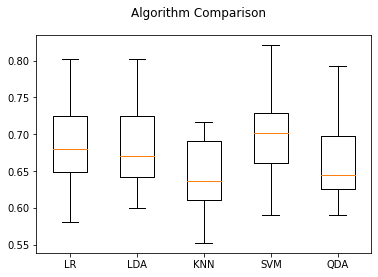

In [62]:
seed = 42
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# compairing Precision

LR: 0.692957 (0.067213)
LDA: 0.694479 (0.063619)
KNN: 0.702437 (0.067076)
SVM: 0.691779 (0.066089)
QDA: 0.705324 (0.053473)


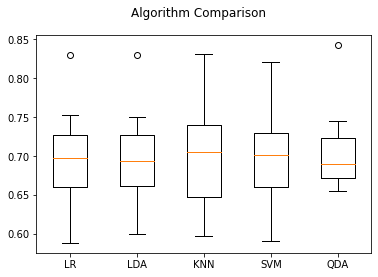

In [63]:
seed = 42
# evaluate each model in turn
results = []
names = []
scoring = 'precision'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Neural network

In [64]:
feature_cols = df.columns[df.columns != "PME"]
X = df[feature_cols]
y = df["PME"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y)

In [65]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train, y_train)
mlp_predictions = mlp.predict(X_test)


C:\Users\rishi\.conda\envs\jupLab\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [66]:
confusion_matrix(y_test,mlp_predictions)

array([[ 19,  63],
       [ 35, 148]], dtype=int64)

In [67]:
print(classification_report(y_test, mlp_predictions))

              precision    recall  f1-score   support

         0.0       0.35      0.23      0.28        82
         1.0       0.70      0.81      0.75       183

    accuracy                           0.63       265
   macro avg       0.53      0.52      0.52       265
weighted avg       0.59      0.63      0.61       265

